# Sparkify: Customers Churn prediction

![Customers Churn](https://thinkml.ai/content/images/2019/11/image-10.png)

## Table of Contents

1. [Overview](#overview)
2. [Load and Clean Dataset](#load_clean)
    1. [Checking for missing values](#check)
    2. [Cleaning the data](#clean)
3. [Exploratory Data Analysis](#eda)
    1. [Descriptive statistics](#stat)
    2. [Defining churn indicator](#churn)
    2. [Data Exploration](#explore)
4. [Feature Engineering](#feature_eng)
5. [Modeling](#modeling)
6. [Conclusion](#conclusion)

## 1. Overview<a id='overview'></a>
This notebooks is done in the context of the Capstone project for `Data Science Nanodegree` Program by Udacity.

Sparkify is a music streaming service like Spotify and Pandora. The users can use the service either the `Premium`  or the `Free Tier`. The premium plan with the monthly fees payment enables the use of service without any advertisements between songs.

The used data contains the user activity logs happening in the service. Those contain visited pages, service upgrade or downgrade events, events timestamps, demographic info, ...

In [1]:
! pip install -r requirements.txt

In [190]:
import datetime
from time import time
import pprint

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, udf
# from pyspark.sql.functions import lit, min as Fmin, max as Fmax
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, DoubleType, LongType, IntegerType, DateType, TimestampType
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

events_data_path = "data/mini_sparkify_event_data.json"

In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [192]:
pp = pprint.PrettyPrinter(indent=4)

In [4]:
# Make the output more like pandas and less like command-line SQL
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '192.168.1.176'),
 ('spark.driver.port', '46853'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1596730654744'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [6]:
spark

# <center> 2. Load and Clean Dataset <a id='load_clean'></a> </center>

1. Load the data.
2. Check for invalid or missing values e.g. records without userids or sessionids. 
3. Clean the data

In [7]:
# Load the Sparkify Events data from a JSON file into a Spark DataFrame
events_df = spark.read.json(events_data_path)
events_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
nb_rows = events_df.count()
print("Number of rows: ", nb_rows)
print("Number of columns: ", len(events_df.columns))

Number of rows:  286500
Number of columns:  18


# Checking for missing data<a id='check'></a>

In [9]:
events_df.select([count(when(isnan(c), c)).alias(c) for c in events_df.columns]).toPandas().T

,0
artist,0
auth,0
firstName,0
gender,0
itemInSession,0
lastName,0
length,0
level,0
location,0
method,0


The data set has no NaNs. In PySpark NaN is not the same as Null. Both of these are also different than an empty string "". So we check also Null values.

In [10]:
null_counts = events_df.select([
    count(when(col(column_name).isNull(), column_name)).alias(column_name)
        for column_name in events_df.columns
    ]).toPandas().T
null_counts

,0
artist,58392
auth,0
firstName,8346
gender,8346
itemInSession,0
lastName,8346
length,58392
level,0
location,8346
method,0


It appears that there are some users with misssing registration field, firstName and lastName. This might be related to non registered users.

### Checking rows with Null value in all columns

In [11]:
events_df.na.drop(how="all").count()

286500

It appears that there is no row with Null value in all columns 

### Check empty user IDs and sessionID

Regardless of the reason (logged out, unregistered...), empty userIds and sessionIds are useless for the purpose of detecting potentially churning users, so we can drop the corresponding records.

In [12]:
events_df.filter((
    events_df["userId"] == "") | events_df["userId"].isNull() | isnan(events_df["userId"])).count()

8346

In [13]:
events_df.filter((
    events_df["sessionId"] == "") | events_df["sessionId"].isNull() | isnan(events_df["sessionId"])).count()
events_df.dropna(how = 'any', subset = ['userId', 'sessionId'])
events_df.count()

286500

Checking for empty sessionId values shows that there are no missing values for sessionId column

### Number of distinct users

In [14]:
events_df = events_df.filter(events_df.userId != '')
events_df.select('userId').distinct().count()

225

### Check for Duplicated events logs
Comparing events_df.count() to events_df.distinct().count() shows that there are no duplicates

In [15]:
events_df.distinct().count()

278154

## Cleaning the data <a id='clean'></a>

In [16]:
def load_and_clean_data(events_data_path):
    """
    Args:
        df: Spark DataFrame
    Return:
        preprocessed Spark DataFrame
    """
    df = spark.read.json(events_data_path)

    df = df.withColumn('event_time', F.from_unixtime(col('ts')\
                        .cast(LongType()) / 1000).cast(TimestampType()))
    df = df.withColumn('month', F.month(col('event_time')))
    df = df.withColumn('weekofyear', F.weekofyear(col('event_time')))
    df = df.withColumn('year', F.year(col('event_time')))
    df = df.withColumn('date', F.from_unixtime(col('ts') / 1000).cast(DateType()))

    df = df.filter(df.userId != '')
    return df

In [17]:
events_df = load_and_clean_data(events_data_path)
events_df.count()

278154

In [18]:
pd.DataFrame(events_df.take(5), columns=events_df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,event_time,month,weekofyear,year,date
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 02:01:57,10,40,2018,2018-10-01
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 02:03:00,10,40,2018,2018-10-01
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 02:06:34,10,40,2018,2018-10-01
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 02:06:56,10,40,2018,2018-10-01
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 02:11:16,10,40,2018,2018-10-01


In [19]:
events_df.count()

278154

### Let's check some of the empty fields e.g. registration, gender, ...

In [20]:
null_counts = events_df.select([count(when(col(column_name).isNull(), column_name)).alias(column_name) for column_name in 
           events_df.columns]).toPandas().T
null_counts

,0
artist,50046
auth,0
firstName,0
gender,0
itemInSession,0
lastName,0
length,50046
level,0
location,0
method,0


<div class="alert alert-block alert-warning">
It appears that the rows with missing values where related to the log events with no userId
</div>

In [21]:
pd.DataFrame(events_df.take(5), columns=events_df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,event_time,month,weekofyear,year,date
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 02:01:57,10,40,2018,2018-10-01
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 02:03:00,10,40,2018,2018-10-01
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 02:06:34,10,40,2018,2018-10-01
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 02:06:56,10,40,2018,2018-10-01
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 02:11:16,10,40,2018,2018-10-01


#  <center> 3. Exploratory Data Analysis<a id='eda'></a> </center>
Here EDA is performed using subset of the data.

# Dataset Timespan

In [22]:
min_ts = events_df.agg({'ts': 'min'}).collect()[0][0]
max_ts = events_df.agg({'ts': 'max'}).collect()[0][0]
print('Dataset timespan: {:.0f} days.'.format((max_ts - min_ts) / (1000*60*60*24)))

Dataset timespan: 63 days.


In [23]:
min_date, max_date = events_df.select(F.min("date"), F.max("date")).first()
min_date, max_date

(datetime.date(2018, 10, 1), datetime.date(2018, 12, 3))

### Removing not needed columns for data exploration and feature engineering

In [24]:
not_needed_columns = ['firstName', 'lastName', 'method', 'userAgent', 'location']
events_df = events_df.drop(*not_needed_columns)

## Descriptive statistics for the length field<a id='load_clean'></a>
Getting some sense of what the data looks like

In [25]:
events_df[["length"]].toPandas().describe()

,length
count,228108.000000
mean,249.117182
std,99.235179
min,0.783220
25%,199.888530
50%,234.500770
75%,277.158730
max,3024.665670


### Get columns unique values

In [28]:
def show_columns_unique_vals(columns):
    for column in columns:
        print (events_df.select(column).distinct())
show_columns_unique_vals(['auth', 'page', 'level', 'status', 'gender'])

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+

+------+
|gender|
+------+
|     F|
|     M|
+------+



### Fields types

In [29]:
numeric_cols = [f.name for f in events_df.schema.fields if 
            isinstance(f.dataType, DoubleType) or isinstance(f.dataType, LongType)
                or isinstance(f.dataType, IntegerType)]
# numeric_cols.remove('ts')
# numeric_cols.remove('registration')
numeric_cols

['itemInSession',
 'length',
 'registration',
 'sessionId',
 'status',
 'ts',
 'month',
 'weekofyear',
 'year']

In [30]:
string_cols = [f.name for f in events_df.schema.fields if 
            isinstance(f.dataType, StringType)]
string_cols

['artist', 'auth', 'gender', 'level', 'page', 'song', 'userId']

# <font color="blue"> Churn indicator <a id='churn'></a> </font>

### Authentication

In [31]:
events_df.createOrReplaceTempView("sparkify_view")
auth_data = spark.sql("""
    SELECT auth, COUNT(DISTINCT userId) as unique_users_count\
    FROM sparkify_view\
    WHERE userId IS NOT NULL AND userID != '' \
    GROUP BY auth \
    ORDER BY unique_users_count DESC
""")
pd.DataFrame(auth_data.collect(), columns=auth_data.columns).head()

,auth,unique_users_count
0,Logged In,225
1,Cancelled,52


`auth` field could represent a churn event.

### Visited Pages overview

In [32]:
pd.DataFrame(
    events_df.select('page','UserId').groupby('page').agg({'page':'count'})\
    .select('page','count(page)').collect(), columns=['page','count(page)'])

,page,count(page)
0,Cancel,52
1,Submit Downgrade,63
2,Thumbs Down,2546
3,Home,10082
4,Downgrade,2055
5,Roll Advert,3933
6,Logout,3226
7,Save Settings,310
8,Cancellation Confirmation,52
9,About,495


### Let's check if the users going to the page `Cancellation Confirmation` are the same as the ones performing the `Cancelled` authentication event. That because the users count for both field is the same

In [33]:
churning_users = spark.sql("""
    SELECT COUNT(DISTINCT userId) as unique_users_count\
    FROM sparkify_view\
    WHERE userId IS NOT NULL AND userID != '' \
     AND auth='Cancelled' AND page='Cancellation Confirmation' 
""")

churning_users.show()

+------------------+
|unique_users_count|
+------------------+
|                52|
+------------------+



<div class="alert alert-block alert-info">
We could define churned users as those users who have visited the `Cancelation Confirmation` page. The action happens for both the Free-tier `level=free` and the Premium Subscription model `level=paid`. We could also consider users performing a `Submit Downgrade` action as churned users.
</div>


In [34]:
churn_users_ids = events_df.filter((events_df.page == 'Cancellation Confirmation') | \
                                   (events_df.page == 'Submit Downgrade'))\
                                            .select('userId')\
                                            .dropDuplicates()\
                                            .rdd.flatMap(lambda x : x)\
                                            .collect()
registered_users_ids = events_df.filter(col('auth') == 'Logged In').select('userId')
nb_registered_users = registered_users_ids.distinct().count()
nb_left_users = len(churn_users_ids)
print("Number of registered users: {}".format(nb_registered_users))
print("Number of churned users: {}".format(nb_left_users))
print("Churn Rate: {:.2f}".format(nb_left_users / nb_registered_users))

Number of registered users: 225
Number of churned users: 92
Churn Rate: 0.41


### Add new column `churn`
Set to `Churner` if the user visits `Cancellation Confirmation` or `Submit Downgrade` pages

In [158]:
events_df = events_df.withColumn('churn', when(col("userId").isin(list(churn_users_ids)),
                                                  "Churner").otherwise("Engaged"))
# events_df.select('churn').distinct().show()

In [159]:
print("Columns", events_df.columns)
numeric_cols.append("churn")
print("Numeric columns are ", numeric_cols)

Columns ['artist', 'auth', 'gender', 'itemInSession', 'length', 'level', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userId', 'event_time', 'month', 'weekofyear', 'year', 'date', 'churn']
Numeric columns are  ['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts', 'month', 'weekofyear', 'year', 'churn', 'churn']


In [37]:
events_df.columns

['artist',
 'auth',
 'gender',
 'itemInSession',
 'length',
 'level',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userId',
 'event_time',
 'month',
 'weekofyear',
 'year',
 'date',
 'churn']

# Data Exploration <a id='explore'></a>
Observing the users behavior in regard of the churning event.

In [38]:
def get_dataframe(dataframe, columns=None, nb_elements=5):
    """Convert a subset of a Spark Dataframe to pandas DataFrame display it
    Args:
        dataframe: sark dataframe
        nb_elements: number of rows to take from the dataframe
    """
    if not columns:
        columns = dataframe.columns
    return pd.DataFrame(dataframe.take(5), columns=columns)

In [39]:
categorical_variables = [ 'auth' , 'gender', 'level', 'page', 'status' ]

for cat in categorical_variables:
    print(cat)
    events_df.groupby(cat).count().sort('count', ascending=False).show()

auth
+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+

gender
+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+

level
+-----+------+
|level| count|
+-----+------+
| paid|222433|
| free| 55721|
+-----+------+

page
+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+-------------

## Customer Churn by account type (Free/Premium)

In [40]:
def change_bar_width(ax, width):
    """Change bar width in barplot
    source: shorturl.at/cfJW6
    Args:
        ax: axis object
        width: new width value
    """
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - width
        patch.set_width(width)
        # recenter the bar
        patch.set_x(patch.get_x() + diff * .8)

def plot_churners_groups_count(data, title, xlabel,
                               column, groups_column, ylabel, palette="Reds_r"):
    """Plot churning and loyal users grouped by column and group_column
    Args:
        data: dataframe
        title: title string
        xlabel: x axis label
        column: column name
        groups_column: group columns list
        ylabel: y axis label
        palette: colors palette
    """
    groups_data = data.dropDuplicates(["userId", column])\
                .groupby([groups_column, column]).count()\
                .sort(groups_column).toPandas()

    ax = sns.barplot(x=groups_column, y="count",
                     hue=column, data=groups_data,
                     dodge=True,
                     palette=palette, alpha=.7)
    change_bar_width(ax, .25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(loc="best")
    plt.title(title, fontsize=14)
#     sns.despine(ax=ax);
    return ax

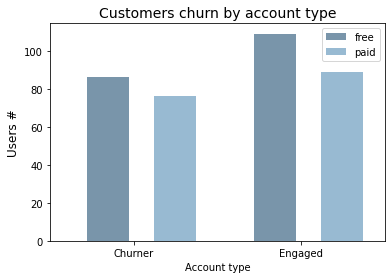

In [41]:
plot_churners_groups_count(events_df, xlabel="Account type",
                           ylabel="Users #",
                           title="Customers churn by account type",
                           column="level", groups_column="churn", palette="Blues_d");

Users with Free account are slight more likely to churn than users with paid account

## Customer Churn by Gender

In [42]:
events_df = events_df \
    .replace(['M', 'F'], ['Male', 'Female'], 'gender')
gender_churn_data = events_df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).\
        count().sort("churn").toPandas()
gender_churn_data

,churn,gender,count
0,Churner,Male,49
1,Churner,Female,43
2,Engaged,Female,61
3,Engaged,Male,72


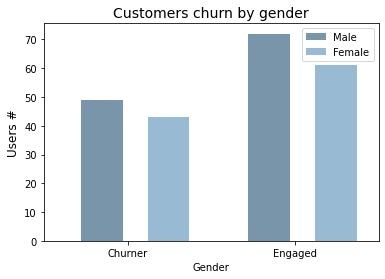

In [43]:
plot_churners_groups_count(events_df, xlabel="Gender", ylabel="Users #",
                           title="Customers churn by gender",
                           column="Gender", groups_column="churn", palette="Blues_d");

Male customers are slight more likely to churn than female customers

## User account age in term of days

In [44]:
account_age_df = events_df \
    .select('userId', 'registration', 'ts', 'churn') \
    .withColumn('last_event', (events_df.ts - events_df.registration)) \
    .groupBy('userId', 'churn') \
    .agg({'last_event': 'max'}) \
    .withColumnRenamed('max(last_event)', 'account_age(days)') \
    .select('userId', 'churn',
            (col('account_age(days)') / (1000 * 60 * 60 * 24)).\
                cast(IntegerType()).alias('account_age(days)')
    ).toPandas()
account_age_df.head()

,userId,churn,account_age(days)
0,73,Churner,49
1,100004,Churner,172
2,36,Engaged,108
3,94,Engaged,132
4,114,Engaged,71


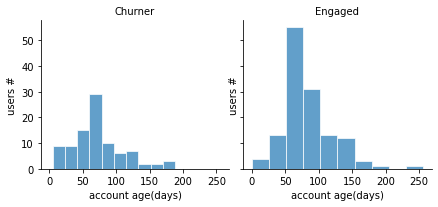

In [45]:
grp = sns.FacetGrid(account_age_df, col="churn", sharey=True)
grp.fig.subplots_adjust(wspace=.05, hspace=.05)
grp = grp.map(plt.hist, "account_age(days)", alpha=.7, edgecolor='w')
for ax in grp.axes.flat:
    ax.set_title(ax.get_title().replace("churn = ", ""), fontsize=10)
    ax.set_ylabel("users #", fontsize=10)
    ax.set_xlabel("account age(days)", fontsize=10)

Users registered for a longer period are more likely to not churn

In [46]:
account_age_df[["account_age(days)"]].describe(percentiles=[0.25, 0.50, 0.75, 0.85, 0.90])

,account_age(days)
count,225.000000
mean,79.364444
std,37.646625
min,0.000000
25%,59.000000
50%,73.000000
75%,100.000000
85%,121.200000
90%,129.800000
max,256.000000


In [47]:
bins=[0, 20, 59, 73, 100, 120, 130]
buckets = range(len(bins) - 1)
print("Number of users for each account age range")
pd.cut(account_age_df["account_age(days)"], bins, buckets).value_counts()

Number of users for each account age range


(59, 73]      58
(73, 100]     55
(20, 59]      49
(100, 120]    21
(120, 130]    11
(0, 20]        7
Name: account_age(days), dtype: int64

## Cumulative Number of users over the last N days of service usage time

In [48]:
def age_filter(ages_df,  min_age):
    """Filter all events with age higher than min_age
    Args:
        ages_df: dataframe
        min_age: minimum ag
    """
    return np.sum(ages_df >= min_age)

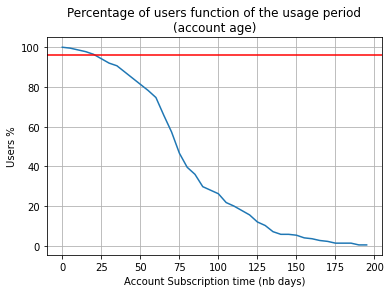

In [ ]:
range_ = range(0, 200, 5)
plt.plot(range_, [100 * age_filter(account_age_df["account_age(days)"], ma) / 
                  age_filter(account_age_df["account_age(days)"], 0) for ma in range_])
plt.axhline(96, color='red')
plt.ylabel("Users %")
plt.xlabel("Account Subscription time (nb days)")
plt.xticks = range(0, 200, 5)
plt.title("Percentage of users function of the usage period\n(account age)")
plt.grid()

<div class="alert alert-block alert-warning">
Keeping ~96% of the users (age greater than 20 days) should be sufficient to have a feature reflecting the service usage distribution over the time before churn event (here the last 20 days).
</div>

In [50]:
len(account_age_df.userId.unique())*.96

216.0

In [51]:
account_age_df[account_age_df["account_age(days)"] >= 20].count()

userId               217
churn                217
account_age(days)    217
dtype: int64

## User account age in term of weeks number

In [52]:
account_agew_df = events_df \
    .select('userId', 'weekofyear', 'churn') \
    .groupBy('userId','churn') \
    .agg(F.min(events_df.weekofyear), F.max(events_df.weekofyear)) \
     .withColumnRenamed('max(weekofyear)', 'max_weekofyear') \
     .withColumnRenamed('min(weekofyear)', 'min_weekofyear') \
    .withColumn('account_age(weeks)', col("max_weekofyear") - col("min_weekofyear")) \
    .toPandas()
account_agew_df.head()

,userId,churn,min_weekofyear,max_weekofyear,account_age(weeks)
0,73,Churner,40,43,3
1,100004,Churner,40,48,8
2,36,Engaged,40,48,8
3,94,Engaged,40,47,7
4,114,Engaged,40,47,7


In [53]:
account_agew_df["account_age(weeks)"].describe()

count    225.000000
mean       5.746667
std        2.654646
min        0.000000
25%        4.000000
50%        7.000000
75%        8.000000
max        8.000000
Name: account_age(weeks), dtype: float64

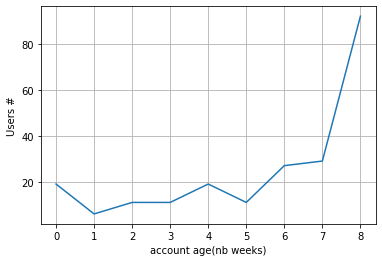

In [169]:
plt.grid()
plt.xlabel("account age(nb weeks)")
plt.ylabel("Users #")
plt.plot(account_agew_df.groupby("account_age(weeks)")["userId"].count());

In [55]:
# from pyspark.mllib.stat import Statidescribes
# col_names = events_df.columns
# features = events_df.rdd.map(lambda row: row[0:])
# corr_mat=Statistics.corr(features, method="pearson")
# corr_df = pd.DataFrame(corr_mat)
# corr_df.index, corr_df.columns = col_names, col_names

## Visited Pages by users type Churner/Engaged

In [56]:
%%javascript
require("notebook/js/notebook").Notebook.prototype.scroll_to_bottom = function () {};

<IPython.core.display.Javascript object>

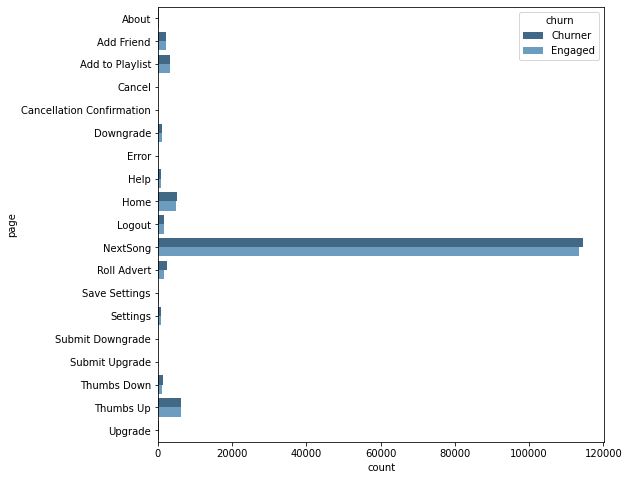

In [57]:
page_data = events_df.select(["page", "churn"])\
            .groupby([ "page","churn"]).count()\
            .sort("page").toPandas()
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x="count", y="page",
            hue="churn", data=page_data,
            palette="Blues_d", ax=ax);

Churning users listen to more songs than the more Engaged users.

In [58]:
pages_count = events_df.groupby(["page"]).count().toPandas().sort_values(by="count", ascending=False)
pages_count["rate"] = (pages_count["count"] / pages_count["count"].sum()).round(4)
pages_count

,page,count,rate
13,NextSong,228108,0.8201
14,Thumbs Up,12551,0.0451
3,Home,10082,0.0362
11,Add to Playlist,6526,0.0235
12,Add Friend,4277,0.0154
5,Roll Advert,3933,0.0141
6,Logout,3226,0.0116
2,Thumbs Down,2546,0.0092
4,Downgrade,2055,0.0074
10,Settings,1514,0.0054


### Filtering out NextSong pages for a more clear visulalization of pages visits count. That because it has a very high number relatively to the other pages

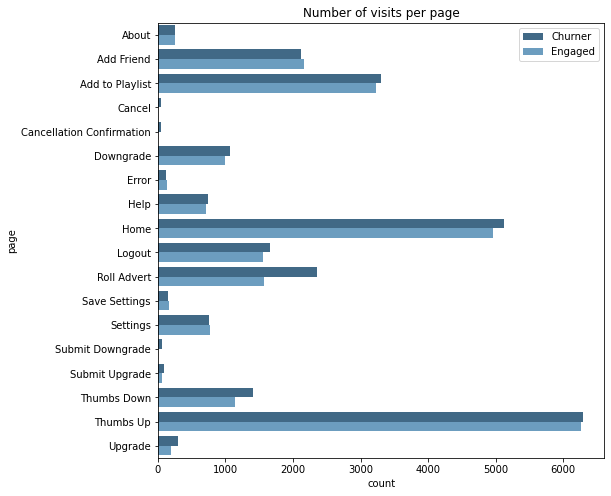

In [59]:
page_data = events_df.select(["page","churn"]).filter(col('page') != 'NextSong').\
    groupby([ "page","churn"]).count().sort("page").toPandas()
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="count", y="page", hue="churn", data=page_data, ax=ax, palette="Blues_d");
plt.title("Number of visits per page")
plt.legend(title="");

It appears that most of the page visit counts can have an effect on the user engagement e.g `Thumbs Down`, `Roll Advert`, `NextSong`

Churning users have higher number of visits to the page `Roll Advert`

##  Measure customer engagement
<div class="alert alert-block alert-info">
 In general, if a customer regularly uses the service, there is nothing to worry about. If, on the other hand, the customer’s usage level drops off, there is a need to find out why it dropped and what to do about it.
 
So let's see how we can measure the service usage and engagement of the users.
</div >

### Average Number of played songs per day for each user

In [60]:
ts_date_day = udf(lambda x: datetime.datetime.utcfromtimestamp(x / 1000), DateType() )

In [61]:
user_avg_songs_per_day = events_df.withColumn("date", ts_date_day(col("ts"))) \
    .where(events_df.page == "NextSong") \
    .select(["userId", "level", "date"]) \
    .groupby([ "level", "userId", "date"]).count() \
    .withColumnRenamed("count", "numSongsPerDay") \
    .groupby([ "level", "userId"]).mean("numSongsPerDay") \
    .withColumnRenamed("avg(numSongsPerDay)", "avgSongsPerDay") \
    .groupby("level").mean() \
    .withColumnRenamed("avg(avgSongsPerDay)", "avgSongsPerDay")
pd.DataFrame(user_avg_songs_per_day.collect(),
    columns=user_avg_songs_per_day.columns)

,level,avgSongsPerDay
0,free,32.318292
1,paid,87.089962


## Service usage over the last 20 days in term of average number of songs number

In [62]:
account_age_in_days = udf(lambda max_date, current_date: (max_date - current_date).days)

usage_days_df1 = events_df \
    .select('userId', 'date', 'churn') \
    .groupBy('userId') \
    .agg(F.max(events_df.date), F.min(events_df.date)) \
    .withColumnRenamed('max(date)', 'last_day') \
    .withColumnRenamed('min(date)', 'first_day') \
    .withColumn("20_days_before", F.date_add(col("last_day"), - 20 + 1))\
    .filter(account_age_in_days(col("last_day"), col("first_day")) >= 20)

last20days_usage_df1 = usage_days_df1 \
    .join(events_df, events_df.userId == usage_days_df1.userId) \
    .where(col('date').between(col('20_days_before'), col('last_day'))) \
    .groupby([events_df.userId, events_df.churn, events_df.userId, events_df.date, col('last_day')]).count() \
    .withColumnRenamed("count", "numSongsPerDay") \
    .withColumn("date_index", account_age_in_days(col("last_day"), col("date"))) \
    .groupby([events_df.churn, "date_index"]).mean("numSongsPerDay") \
    .withColumnRenamed("avg(numSongsPerDay)", "avgSongsPerDay") \
    .orderBy(events_df.churn, col("date_index").cast("int").asc())

# get list of users ids
# users_ids = last20days_usage_df1.select("userId").distinct().rdd.map(lambda r: r[0]).collect()

# TODO use one single query to get the data instead of joining the dataframes

In [63]:
# Number of songs per day per user in the last 20 days
last20days_usage_df1.toPandas().head(20)

,churn,date_index,avgSongsPerDay
0,Churner,0,78.117647
1,Churner,1,104.156250
2,Churner,2,118.105263
3,Churner,3,117.115385
4,Churner,4,105.500000
5,Churner,5,107.760000
6,Churner,6,70.606061
7,Churner,7,100.777778
8,Churner,8,68.259259
9,Churner,9,92.571429


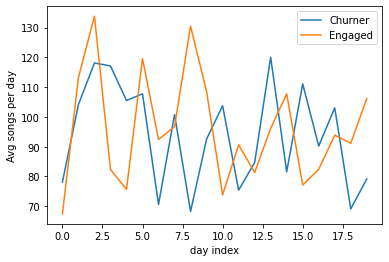

In [170]:
usage_data = last20days_usage_df1.toPandas()
usage_data['date_index'] = usage_data.date_index.apply(lambda x: int(x))

# grp = sns.FacetGrid(usage_data, col="churn", sharey=True)
# grp.fig.subplots_adjust(wspace=.05, hspace=.05)
plt.plot(usage_data[usage_data.churn == "Churner"]["date_index"].values,
        usage_data[usage_data.churn == "Churner"]["avgSongsPerDay"].values,
        label="Churner");
plt.plot(usage_data[usage_data.churn == "Engaged"]["date_index"].values,
        usage_data[usage_data.churn == "Engaged"]["avgSongsPerDay"].values,
        label="Engaged");
plt.legend()
plt.ylabel("Avg songs per day", fontsize=10)
plt.xlabel("day index", fontsize=10)
plt.xticks = range(0, 20, 2)
plt.show()

The number of songs for `churning` users is decreasing over the last 20 days of logged events in the service.

<!-- ### Average Number of played songs per month for each user -->

In [65]:
# user_avg_songs_per_month = events_df.withColumn("date", ts_date_day(col("ts"))) \
#     .where(events_df.page == "NextSong") \
#     .select(["userId", "month", "year"]) \
#     .groupby(["userId", "month", "year"]).count() \
#     .withColumnRenamed("count", "numSongsPerMonth") \
#     .groupby(["month", "year", "userId" ]).mean("numSongsPerMonth") \
#     .withColumnRenamed("avg(numSongsPerMonth)", "avgSongsPerMonth")
# df = pd.DataFrame(user_avg_songs_per_month.collect(),
#     columns=user_avg_songs_per_month.columns)
# df

<!-- ### Average Number of played songs per week for each user -->

In [66]:
# user_avg_songs_per_week = events_df.withColumn("date", ts_date_day(col("ts"))) \
#     .where(events_df.page == "NextSong") \
#     .select(["userId", "weekofyear"]) \
#     .groupby(["userId", "weekofyear"]).count() \
#     .withColumnRenamed("count", "numSongsPerWeek") \
#     .groupby(["weekofyear", "userId" ]).mean("numSongsPerWeek") \
#     .withColumnRenamed("avg(numSongsPerWeek)", "avgSongsPerWeek")
# df = pd.DataFrame(user_avg_songs_per_week.collect(),
#     columns=user_avg_songs_per_week.columns)
# df

### Average Number of songs per session per account type

In [67]:
# 1. Compute average number of songs per session for each user
# 2. Average across users for each account type
user_avg_songs_per_session = events_df.where(events_df.page == "NextSong") \
    .select(["userId", "level", "sessionId"]) \
    .groupby(["level", "userId", "sessionId"]).count() \
    .withColumnRenamed("count", "nb_songs_sessions") \
    .groupby(["level", "userId"]).mean("nb_songs_sessions") \
    .withColumnRenamed("avg(nb_songs_sessions)", "SongsPerSession")\
    .groupby("level").mean()\
    .withColumnRenamed("avg(SongsPerSession)", "avgSongsPerSession")
pd.DataFrame(user_avg_songs_per_session.collect(),
    columns=user_avg_songs_per_session.columns)

,level,avgSongsPerSession
0,free,31.289821
1,paid,102.625258


We observe that users with Premium account (paid) listen to more songs than the users using Free Tier account.
The reason for that might be the non showed ads to them compared to the users with the Free account. 

But it might be possible that users with decreasing number of songs per session would churn as they are less engaged to the service over the time.

### Average Number of songs per session per user type

In [171]:
from pyspark.sql.functions import desc
user_avg_songs = events_df.where(events_df.page == "NextSong") \
    .select(["userId", "churn", "sessionId"]) \
    .groupby(["churn", "userId", "sessionId"]).count() \
    .withColumnRenamed("count", "nb_songs_sessions") \
    .groupby(["churn", "userId"]).mean("nb_songs_sessions") \
    .withColumnRenamed("avg(nb_songs_sessions)", "SongsPerSession")\
    .groupby("churn").mean() \
    .withColumnRenamed("avg(SongsPerSession)", "avgSongsPerSession")

pd.DataFrame(user_avg_songs.collect(),
    columns=user_avg_songs.columns)

,churn,avgSongsPerSession
0,Engaged,72.858996
1,Churner,72.041926


The number of songs per session seem to be quite similar for both churning and engaged users

### Number of items distribution per session

In [69]:
def plot_facet_grid(data, avg_column, xlabel, ylabel,
                    grp_col1="churn", grp_col2="userId"):
    """
    Plot field distribution for each churning and loyal users
    Args:
        data: Spark dataframe
    """
    item_df = data.groupBy([grp_col2, grp_col1]).avg(avg_column).toPandas()
    grps = sns.FacetGrid(item_df, col=grp_col1, sharey=True, palette="Blues_d",
                        size=4, aspect=1)
    grps.map(plt.hist, "avg({})".format(avg_column), alpha=.7, edgecolor='w');
    for ax in grps.axes.flat:
        ax.set_title(ax.get_title().replace("churn = ", ""), fontsize=10)
        # This only works for the left ylabels
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_xlabel(xlabel, fontsize=10)

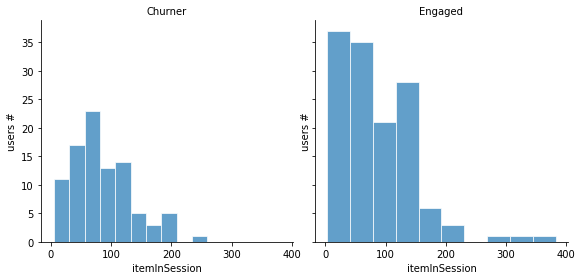

In [70]:
plot_facet_grid(events_df, "itemInSession", "itemInSession", "users #")

Number of items per session is higher for engaged users. This might be because the engaged users can find more songs they like to listen to in the service platform.

### User sessions number distribution

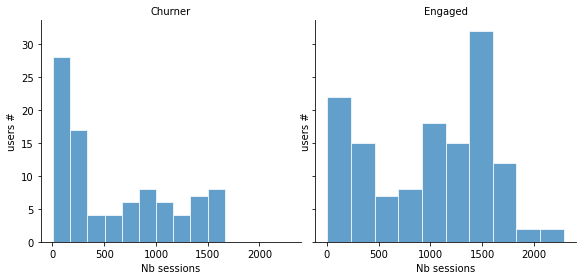

In [71]:
plot_facet_grid(events_df, "sessionId", "Nb sessions", "users #");

Number of sessions per user are less for churning users

### User Thumbs Up events number distribution

In [72]:
def clean_subplots_title(grp_ax, xlabel, ylabel):
    """Clen out subplots titles
    Args:
        grp_ax: Axes list
    """
    for ax in grps.axes.flat:
        ax.set_title(ax.get_title().replace("churn = ", ""), fontsize=10)
        # This only works for the left ylabels
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_xlabel(xlabel, fontsize=10)

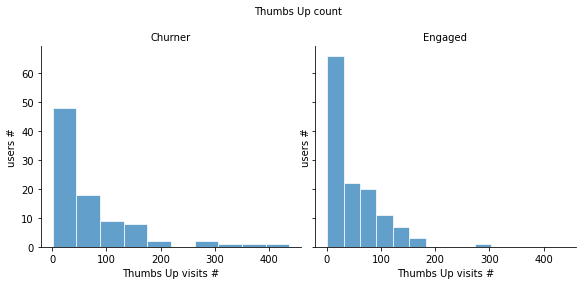

In [73]:
item_df = events_df.filter(events_df.page=="Thumbs Up").groupBy(["userId", "churn"]).count().toPandas()
grps = sns.FacetGrid(item_df, col="churn", sharey=True,
                    size=4, aspect=1)
grps.fig.suptitle("Thumbs Up count", size=10)
grps.fig.subplots_adjust(top=.8)
grps.map(plt.hist, "count", alpha=.7, edgecolor="w")
clean_subplots_title(grps, "Thumbs Up visits #", "users #")

### User Thumbs Down events number distribution

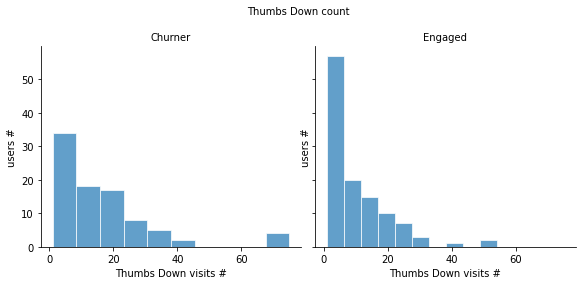

In [74]:
item_df = events_df.filter(events_df.page=="Thumbs Down").groupBy(["userId", "churn"]).count().toPandas()
grps = sns.FacetGrid(item_df, col="churn", sharey=True,
                    size=4, aspect=1)
grps.fig.suptitle("Thumbs Down count", size=10)
grps.fig.subplots_adjust(top=.9)
grps.map(plt.hist, "count", alpha=.7, edgecolor="w");
clean_subplots_title(grps, "Thumbs Down visits #", "users #")

### Observation
It appears that churning users have less interactions in regard of giving a Thumbs up or down to a song.

## Number of errors distribution

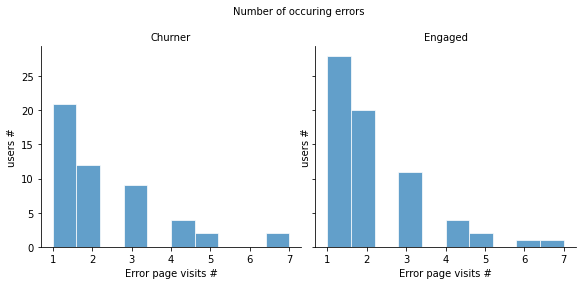

In [75]:
item_df = events_df.filter(events_df.page=="Error") \
            .groupBy(["userId", "churn"]).count().toPandas()
grps = sns.FacetGrid(item_df, col="churn", sharey=True,
                     palette="Blues_d", size=4, aspect=1)
grps.fig.suptitle("Number of occuring errors", size=10)
grps.fig.subplots_adjust(top=.9)
# grps.set_titles('{col_name}')
grps = grps.map(plt.hist, "count", alpha=.7, edgecolor="w");
clean_subplots_title(grps, "Error page visits #", "users #")

We observe that on average each of the users (churning or engaged) got the same number of error pages

#  <center> 4. Feature Engineering<a id='feature_eng'></a> </center>
Used features for the model:
```
    - Number of songs per day over the last 20 days (array of 20 values)
    - registration_days (label encoded)
    - Average daily session duration
    - Average monthly session duration
    - Number of errors events
    - Number of songs per session
    - Number of thumbs up
    - Number of thumbs down
    - Last level of the user (Paid or Free)
    - Number of unique artists the user listened to
    - Daily number of items per session over the last 20 days (array of 20 values)
    - User Account age in days: uage duration since first log event day
````

## Service usage over the last 20 days

In [76]:
account_age_in_days = udf(lambda max_date, current_date:
                          (max_date - current_date).days)

usage_days_df = events_df \
    .select('userId', 'date', 'churn') \
    .groupBy('userId') \
    .agg(F.max(events_df.date), F.min(events_df.date)) \
    .withColumnRenamed('max(date)', 'last_day') \
    .withColumnRenamed('min(date)', 'first_day') \
    .withColumn("20_days_before", F.date_add(col("last_day"), - 20 + 1))\
    .filter(account_age_in_days(col("last_day"), col("first_day")) >= 20)

usage_last20days_df = usage_days_df \
    .join(events_df, events_df.userId == usage_days_df.userId) \
    .where(col('date').between(col('20_days_before'), col('last_day'))) \
    .groupby([events_df.userId, events_df.date, col('last_day')]).count() \
    .orderBy("userId", col("date").asc()) \
    .withColumn("date_index", account_age_in_days(col("last_day"), col("date"))) \
    .withColumn("date_index", col("date_index").cast('int'))

In [77]:
# get list of users ids
users_ids = usage_last20days_df.select("userId").distinct().rdd.map(lambda r: r[0]).collect()
len(users_ids)

188

In [78]:
usage_last20days_df.toPandas().head()

,userId,date,last_day,count,date_index
0,10,2018-11-03,2018-11-19,78,16
1,10,2018-11-15,2018-11-19,57,4
2,10,2018-11-16,2018-11-19,21,3
3,10,2018-11-19,2018-11-19,95,0
4,100,2018-11-13,2018-11-30,7,17


In [79]:
def vector_builder(grp):
    """Build feature vector from aggregated count
    data for each user
    Args:
        grp: ndarray of columns values
    """
    vector = np.zeros(20)
    for count, index in grp[['count', 'date_index']].values:
        vector[index] = count
    return pd.Series(vector)
        
usage_last20days_features = usage_last20days_df.toPandas().groupby('userId').apply(vector_builder).reset_index()

In [80]:
usage_last20days_features

,userId,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,10,95.0,0.0,0.0,21.0,57.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0
1,100,91.0,196.0,0.0,0.0,23.0,0.0,0.0,30.0,0.0,...,169.0,109.0,0.0,0.0,36.0,250.0,86.0,7.0,0.0,0.0
2,100002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,115.0
3,100004,59.0,95.0,244.0,0.0,9.0,0.0,0.0,0.0,17.0,...,0.0,0.0,0.0,0.0,70.0,0.0,168.0,0.0,0.0,0.0
4,100007,200.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,95,22.0,27.0,0.0,62.0,0.0,0.0,0.0,129.0,9.0,...,0.0,31.0,37.0,0.0,0.0,0.0,22.0,0.0,59.0,0.0
184,96,10.0,81.0,0.0,311.0,310.0,34.0,0.0,36.0,0.0,...,79.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0
185,97,27.0,0.0,0.0,0.0,333.0,0.0,0.0,73.0,23.0,...,216.0,88.0,84.0,0.0,3.0,228.0,133.0,0.0,0.0,0.0
186,98,61.0,0.0,63.0,0.0,0.0,0.0,87.0,65.0,228.0,...,187.0,274.0,0.0,0.0,229.0,137.0,0.0,0.0,0.0,35.0


In [81]:
print("Number of unique users", len(usage_last20days_features.userId.unique()))

Number of unique users 188


### keep only users with account age older than 20 days

In [84]:
events_df = events_df[events_df.userId.isin(users_ids)]
nb_users = events_df.select('userId').distinct().count()
nb_users

188

### Number of days since user registration: `registration_days`

In [85]:
def registration_days(df):
    """
    Calculates number of days between registration to last user associated event
    Args:
        df: spark DataFrame
    Return:
        df Dataframe with calculated column
    """
    last_event_df = df.groupBy("userId").max("ts").withColumnRenamed("max(ts)", "last_event")
    df = last_event_df.join(df, on="userId") \
        .withColumn("registration_days",
                    ((col("last_event") - col("registration")) / (1000 * 60 * 60 * 24)) \
        .cast(IntegerType())).select("userId", "registration_days")
    return df
registration_df = registration_days(events_df)
assert registration_df.select('userId').distinct().count() == nb_users

In [86]:
pd.DataFrame(registration_df.take(5), columns=registration_df.columns)

,userId,registration_days
0,100010,55
1,100010,55
2,100010,55
3,100010,55
4,100010,55


### Average Daily and Monthly session duration per user" `avg_daily_session_duration` and `avg_monthly_session_duration`

In [87]:
def session_durations(df):
    """
    Calculates average daily and monthly session duration per user
    Args: 
        df: spark DataFrame
    Return: 
        daily session duration dataframe
    """

    daily_session_duration_df = df.groupby('userId','date','sessionId') \
            .agg(F.max('ts'), F.min('ts')) \
            .withColumn('session_duration_sec', (col('max(ts)') - col('min(ts)')) * 0.001) \
            .groupby('userId','date') \
            .avg('session_duration_sec') \
            .groupby('userId') \
            .agg(F.mean('avg(session_duration_sec)').alias('avg_daily_session_duration')) \
            .orderBy('userId', ascending=False)
    
    monthly_session_duration_df = df.groupby('userId','month','sessionId') \
            .agg(F.max('ts').alias('session_end'), F.min('ts').alias('session_start')) \
            .withColumn('session_duration_sec', (col('session_end') - col('session_start')) * 0.001) \
            .groupby('userId','month') \
            .avg('session_duration_sec') \
            .groupby('userId') \
            .agg(F.mean('avg(session_duration_sec)').alias('avg_monthly_session_duration')) \
            .orderBy('userId', ascending=False)

    return daily_session_duration_df.join(monthly_session_duration_df, on='userId')

sess_duration = session_durations(events_df)

assert sess_duration.count() == nb_users

get_dataframe(sess_duration)

,userId,avg_daily_session_duration,avg_monthly_session_duration
0,100010,9269.000000,9693.500000
1,200002,11924.250000,21529.200000
2,124,25218.162037,35410.519231
3,7,5258.428571,5003.583333
4,15,24441.500000,31866.222222


### Average Daily and Monthly number of items per session" `avg_daily_items` and`avg_monthly_items`

In [88]:
def items_averages(df):
    """
    Calculate average number of items per session for each user(daily and monthly)
    Args:
        df: Spark DataFrame
    Return:
        daily and monthly averages DataFrame
    """
    daily_items_df = df.groupby('userId','date') \
        .max('itemInSession') \
        .groupBy('userId').avg('max(itemInSession)') \
        .withColumnRenamed('avg(max(itemInSession))', 'avg_daily_items')
    
    monthly_items_df = df.groupby('userId','month') \
        .max('itemInSession') \
        .groupBy('userId').avg('max(itemInSession)') \
        .withColumnRenamed('avg(max(itemInSession))', 'avg_monthly_items')
    
    return daily_items_df.join(monthly_items_df, on='userId')

items_averages_df = items_averages(events_df)
assert items_averages_df.count() == nb_users
get_dataframe(items_averages_df)

,userId,avg_daily_items,avg_monthly_items
0,100010,54.428571,85.0
1,200002,82.375000,150.0
2,124,196.444444,530.0
3,7,28.428571,60.0
4,15,154.611111,367.0


### Number of errors: `nb_errors`

In [89]:
errors_df = events_df.filter(events_df.page=="Error") \
            .groupBy(["userId"]).count() \
            .withColumnRenamed('count', 'nb_errors')
print(errors_df.count())
# errors_df.show(5)
get_dataframe(errors_df)

110


,userId,nb_errors
0,124,6
1,7,1
2,15,2
3,54,1
4,155,3


### Fill missing values with zeros

In [90]:
from pyspark.sql.window import Window as W

def impute_missing_values(df, column_name, original_df):
    """Set the number of errors to zero for the users not having any error event
    Args:
        df: Spark dataFrame
        original_df: spark dataframe with the rest of userIds\
            having missing values
    Return:
        df with missing values set to zero
    """
    df_usersids = list(df.select('userId') \
                           .dropDuplicates().rdd.flatMap(lambda x : x) \
                           .collect())
    missing_ids = original_df.filter(~original_df.userId.isin(df_usersids)).select('userId') \
                                    .dropDuplicates().rdd.flatMap(lambda x : x).collect()

    other_users_df = spark.createDataFrame([(userId, 0) for userId in missing_ids], ['userId', column_name])
    df = df.union(other_users_df)
    
    return df

errors_df = impute_missing_values(errors_df, 'nb_errors', events_df)
assert errors_df.count() == nb_users
get_dataframe(errors_df)

,userId,nb_errors
0,124,6
1,7,1
2,15,2
3,54,1
4,155,3


### Gender: `gender`

In [91]:
gender_df = events_df \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['Male', 'Female'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
assert gender_df.count() == nb_users
get_dataframe(gender_df)

,userId,gender
0,147,0
1,200005,0
2,200007,1
3,98,0
4,3,0


### Account level" `last_level`

In [92]:
# level_df = events_df \
#     .select("userId", "level") \
#     .dropDuplicates() \
#     .replace(['paid', 'free'], ['0', '1'], 'level') \
#     .select('userId', col('level').cast('int')).distinct()
# print(level_df.count())
# get_dataframe(level_df)

As the user level can change over the time, we need to keep only the last level for the feature value

In [93]:
level_df = events_df.orderBy('ts', ascending=False).groupBy('userId') \
                .agg(F.first('level').alias('last_level')) \
                .replace(['free', 'paid'], ['0', '1'], 'last_level') \
                .select('userId', col('last_level').cast('int'))

assert level_df.count() == nb_users
get_dataframe(level_df)

,userId,last_level
0,100010,0
1,200002,1
2,124,1
3,7,0
4,15,1


### Churn label: `churn`

In [94]:
label_df = events_df \
    .select("userId", "churn") \
    .dropDuplicates() \
    .replace(['Churner', 'Engaged'], ['1', '0'], 'churn') \
    .select('userId', col('churn').cast('int'))

assert label_df.count() == nb_users

get_dataframe(label_df)

,userId,churn
0,73,1
1,100004,1
2,36,0
3,94,0
4,114,0


### Number of songs per session: `avg_songs_played`

In [95]:
songs_df = events_df.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .avg('count') \
    .withColumnRenamed('avg(count)', 'avg_songs_played')
assert songs_df.count() == nb_users
get_dataframe(songs_df)

,userId,avg_songs_played
0,100010,39.285714
1,200002,64.500000
2,124,145.678571
3,7,21.428571
4,54,81.171429


### Number of artists each user listens to: `nb_artists`

In [96]:
nb_artists_df = events_df \
    .filter(events_df.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "nb_artists")
assert nb_artists_df.count() == nb_users
get_dataframe(nb_artists_df)

,userId,nb_artists
0,100010,252
1,200002,339
2,124,2232
3,7,142
4,15,1302


### Number of Thumbs up and Thumbs down events `num_thumbs_up` and `num_thumbs_down`

In [97]:
thumbs_up_df = events_df.select('userId','page').filter(events_df.page=="Thumbs Up") \
    .groupBy(["userId"]).count()\
    .withColumnRenamed('count', 'num_thumbs_up') 
thumbs_down_df = events_df.filter(events_df.page=="Thumbs Down") \
    .groupBy(["userId"]).count() \
    .withColumnRenamed('count', 'num_thumbs_down')
print("ThumbsUp", thumbs_up_df.count())
print("ThumbsDown", thumbs_down_df.count())
get_dataframe(thumbs_down_df)

ThumbsUp 187
ThumbsDown 177


,userId,num_thumbs_down
0,100010,5
1,200002,6
2,124,41
3,7,1
4,15,14


In [98]:
get_dataframe(thumbs_down_df)

,userId,num_thumbs_down
0,100010,5
1,200002,6
2,124,41
3,7,1
4,15,14


In [99]:
thumbs_down_df = impute_missing_values(thumbs_down_df, 'num_thumbs_down', events_df)
thumbs_up_df = impute_missing_values(thumbs_up_df, 'num_thumbs_up', events_df)
assert thumbs_up_df.count() == nb_users
assert thumbs_down_df.count() == nb_users

## Create features vectors by joining all extracted features

In [100]:
from pyspark.sql import SQLContext
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

usage_last20days_features = sqlContext.createDataFrame(usage_last20days_features)

all_aggs_df = thumbs_up_df \
    .join(thumbs_down_df, on='userId')\
    .join(songs_df, on='userId') \
    .join(level_df, on='userId') \
    .join(errors_df, on='userId') \
    .join(sess_duration, on='userId') \
    .join(items_averages_df, on='userId') \
    .join(registration_df, on='userId') \
    .join(nb_artists_df, on='userId') \
    .join(label_df, on='userId') \
    .join(usage_last20days_features, on='userId')

    Number of thumbs up
    Number of thumbs down
    Last level of the user (Paid or Free)
    Number of unique artists the user listened to
    Daily number of items per session over the last 20 days (array of 20 values)
    User Account age in days: uage duration since first log event day
        
features_df = all_aggs_df.drop_duplicates()
pd.DataFrame(features_df.take(5), columns=features_df.columns).head()

,userId,num_thumbs_up,num_thumbs_down,avg_songs_played,last_level,nb_errors,avg_daily_session_duration,avg_monthly_session_duration,avg_daily_items,avg_monthly_items,...,10,11,12,13,14,15,16,17,18,19
0,100010,17,5,39.285714,0,0,9269.000000,9693.500000,54.428571,85.0,...,0.0,0.0,112.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0
1,200002,21,6,64.500000,1,0,11924.250000,21529.200000,82.375000,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,124,171,41,145.678571,1,6,25218.162037,35410.519231,196.444444,530.0,...,56.0,152.0,0.0,0.0,13.0,162.0,0.0,117.0,89.0,387.0
3,7,7,1,21.428571,0,1,5258.428571,5003.583333,28.428571,60.0,...,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0
4,15,81,14,136.714286,1,2,24441.500000,31866.222222,154.611111,367.0,...,171.0,38.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
cols = ['count', 'date_index', 'last_day', 'date']
features_df.drop(*cols)

userId,num_thumbs_up,num_thumbs_down,avg_songs_played,last_level,nb_errors,avg_daily_session_duration,avg_monthly_session_duration,avg_daily_items,avg_monthly_items,registration_days,nb_artists,churn,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
100010,17,5,39.285714285714285,0,0,9269.0,9693.5,54.42857142857143,85.0,55,252,0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0
200002,21,6,64.5,1,0,11924.25,21529.2,82.375,150.0,70,339,0,9.0,131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,171,41,145.67857142857142,1,6,25218.162037037036,35410.519230769234,196.44444444444446,530.0,131,2232,0,1.0,129.0,72.0,52.0,0.0,0.0,0.0,47.0,0.0,0.0,56.0,152.0,0.0,0.0,13.0,162.0,0.0,117.0,89.0,387.0
7,7,1,21.428571428571427,0,1,5258.428571428572,5003.583333333333,28.428571428571427,60.0,72,142,0,4.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0
15,81,14,136.71428571428572,1,2,24441.5,31866.22222222222,154.61111111111111,367.0,56,1302,0,104.0,136.0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,171.0,38.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,163,29,81.17142857142858,1,1,16807.47311827957,18386.166666666664,142.61290322580646,443.0,110,1744,1,41.0,81.0,80.0,146.0,0.0,213.0,116.0,1.0,0.0,117.0,66.0,117.0,196.0,0.0,49.0,0.0,0.0,32.0,46.0,127.0
155,58,3,136.66666666666666,1,3,23720.75,32914.333333333336,144.375,334.0,23,643,0,236.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,217.0,66.0,30.0,33.0,0.0,0.0,0.0,230.0
100014,17,3,42.833333333333336,1,0,11088.833333333334,10144.375,51.833333333333336,83.5,85,233,1,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132,96,17,120.5,1,3,20333.81818181818,27680.016666666663,148.77272727272728,393.0,66,1299,0,224.0,0.0,83.0,34.0,0.0,24.0,100.0,249.0,206.0,98.0,0.0,0.0,32.0,13.0,0.0,50.0,128.0,0.0,46.0,381.0
154,11,0,28.0,0,0,6641.0,6641.0,41.333333333333336,69.0,23,78,0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0


In [102]:
assert len(features_df.columns) == 33

In [103]:
features_df.count()

188

In [104]:
features_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- num_thumbs_up: long (nullable = true)
 |-- num_thumbs_down: long (nullable = true)
 |-- avg_songs_played: double (nullable = true)
 |-- last_level: integer (nullable = true)
 |-- nb_errors: long (nullable = true)
 |-- avg_daily_session_duration: double (nullable = true)
 |-- avg_monthly_session_duration: double (nullable = true)
 |-- avg_daily_items: double (nullable = true)
 |-- avg_monthly_items: double (nullable = true)
 |-- registration_days: integer (nullable = true)
 |-- nb_artists: long (nullable = false)
 |-- churn: integer (nullable = true)
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- 8: double (nullable = true)
 |-- 9: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true

## Vectorizing the features

In [110]:
from pyspark.ml.feature import VectorAssembler

features = [col for col in features_df.columns if col not in ('userId','churn')]

# Vectorizing the features
assembler = VectorAssembler(inputCols=features, outputCol='features')
modelvec_df = assembler.transform(features_df)

modelvec_df = modelvec_df.select(col('features'), col('churn').alias('label'))

#  <center> 5. Modeling<a id='modeling'></a> </center>

Tree-based algorithms are not sensitive to the scale of the features. While Logistic Regression perform poorly when features differ widely in scale. As we are going to try Random Forest asn Gradient Based Trees algorithms we would not need to scale the data.

In [111]:
from pyspark.ml.feature import StandardScaler

# Scaling to mean 0 and unit std dev
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
model_scaler = scaler.fit(modelvec_df)

modelvec_scaled = model_scaler.transform(modelvec_df)

model_data = modelvec_scaled.select(col('scaled_features').alias('features'), col('label'))

In [112]:
model_data.columns

['features', 'label']

In [113]:
model_data.count()

188

### Split the dataset into train and test sets

In [114]:
# Usually the data should be splitted in train, test and validation datasets 
#   but due to small amount of data here
#   we will be using only train and validation data
# 80% train and 20% validation set
train_df, validation_df = model_data.randomSplit([0.8, 0.2], seed=42)
print("Training set size: ", train_df.count())
print("Validation set size: ", validation_df.count())

Training set size:  157
Validation set size:  31


## Models training and evaluation
We try out various models to see how they compare and perform. Then select the winning model based on the F1 score.

We also perform hyperparameters tuning using `ParamGridBuilder`

Given churned users are a fairly small subset, we decided to use F1 Score and accuracy metric to evalute the model performance.

> `F1 score`: balances the tradeoff between precision and recall.
\begin{equation*}
2 * \frac{precision . recall}{precision + recall}
\end{equation*}
    `Accuracy`: describes the proportion of correct classifications
\begin{equation*}
\frac{TP + TN}{TP + FP + TN + FN}
\end{equation*}
where: TP = True positive; FP = False positive; TN = True negative; FN = False negative 

## Logistic Regression

In [168]:
%%time
results = {}
lr_model = LogisticRegression(
    featuresCol = "features",
    labelCol = "label")

paramGrid = ParamGridBuilder() \
            .addGrid(lr_model.elasticNetParam,[0.0, 0.5, 1.0]) \
            .addGrid(lr_model.maxIter,[20, 70]) \
            .build()
f1_evaluator = MulticlassClassificationEvaluator(metricName="f1")
crossval_lr = CrossValidator(estimator=lr_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=5)

start = time()
cv_model_lr = crossval_lr.fit(train_df)
end = time()
print("The training process took {} seconds".format(end - start))

The training process took 2275.3742883205414 seconds
CPU times: user 50.8 s, sys: 31.3 s, total: 1min 22s
Wall time: 37min 55s


In [196]:
bestModel = cv_model_lr.bestModel
# Save the best model
cv_model_lr.bestModel.save("models/logistic_regression_model")

In [172]:
results_lr = cv_model_lr.transform(validation_df)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
results = {}
results["Logistic Regression"] = {
    "F1 Score": round(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"}), 4),
    "Accuracy": round(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"}), 4),
    "Training Time": end - start
}
print('Logistic Regression Evaluation:')
print('Accuracy: {}'.format(results["Logistic Regression"]["Accuracy"]))
print('F-1 Score: {}'.format((results["Logistic Regression"]["F1 Score"])))
# bestModel.extractParamMap()

Logistic Regression Evaluation:
Accuracy: 0.6129
F-1 Score: 0.5825


In [128]:
results_lr = cv_model_lr.transform(validation_df)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
results = {}
results["Logistic Regression"] = {
    "F1 Score": round(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"}), 4),
    "Accuracy": round(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"}), 4),
    "Training Time": end - start
}
print('Logistic Regression Evaluation:')
print('Accuracy: {}'.format(results["Logistic Regression"]["Accuracy"]))
print('F-1 Score: {}'.format((results["Logistic Regression"]["F1 Score"])))

Logistic Regression Evaluation:
Accuracy: 0.6452
F-1 Score: 0.6246


In [194]:
pp.pprint({param[0].name: param[1] for param in cv_model_lr.extractParamMap().items()})

{   'estimator': LogisticRegression_56cb79a891cd,
    'estimatorParamMaps': [   {   Param(parent='LogisticRegression_56cb79a891cd', name='maxIter', doc='max number of iterations (>= 0).'): 20,
                                  Param(parent='LogisticRegression_56cb79a891cd', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
                              {   Param(parent='LogisticRegression_56cb79a891cd', name='maxIter', doc='max number of iterations (>= 0).'): 70,
                                  Param(parent='LogisticRegression_56cb79a891cd', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
                              {   Param(parent='LogisticRegression_56cb79a891cd', name='maxIter', doc='max number of iterations (>= 0).'): 20,
                   

## Random Forest

In [181]:
%%time

rf_model = RandomForestClassifier(
        featuresCol = "features",
        labelCol = "label",
        maxMemoryInMB = 1000,
        seed = 42
    )
# Create a parameter grid for tuning the model
paramGrid = ParamGridBuilder() \
        .addGrid(rf_model.maxDepth, [3, 5, 10]) \
        .addGrid(rf_model.maxBins, [5, 10, 20]) \
        .addGrid(rf_model.numTrees, [20, 50, 100]) \
        .build()
f1_evaluator = MulticlassClassificationEvaluator(metricName="f1")
crossval_rf = CrossValidator(estimator=rf_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=5)

start = time()
cv_model_rf = crossval_rf.fit(train_df)
end = time()
print("The training process took {} seconds".format(end - start))
# Save the best model
cv_model_rf.bestModel.save("models/random_forest_model");

The training process took 3830.5083994865417 seconds
CPU times: user 1min 10s, sys: 35.3 s, total: 1min 46s
Wall time: 1h 3min 54s


In [182]:
results_rf = cv_model_rf.transform(validation_df)
evaluator_rf = MulticlassClassificationEvaluator(predictionCol="prediction")
results["Random Forest"] = {
    "F1 Score": round(evaluator_rf.evaluate(results_rf,
                                            {evaluator_rf.metricName: "f1"}), 4),
    "Accuracy": round(evaluator_rf.evaluate(results_rf,
                                            {evaluator_rf.metricName: "accuracy"}), 4),
    "Training Time": end - start
}
print('Random Forest Evaluation:')
print('Accuracy: {}'.format(results["Random Forest"]["Accuracy"]))
print('F-1 Score: {}'.format(results["Random Forest"]["F1 Score"]))

Random Forest Evaluation:
Accuracy: 0.5806
F-1 Score: 0.5116


In [193]:
tree_cv = cv_model_rf.bestModel
# print(treeCV.toDebugString) #print the nodes of the decision tree model
feature_importances = list(zip(features, tree_cv.featureImportances))
feature_importances.sort(key = lambda x: x[1], reverse=True)
pp.pprint(feature_importances)

[   ('num_thumbs_up', 0.07733204940513239),
    ('num_thumbs_down', 0.07143424675508053),
    ('nb_artists', 0.06605925989153968),
    ('avg_songs_played', 0.05230490797697774),
    ('registration_days', 0.04927495433027354),
    ('5', 0.04916401459911983),
    ('avg_monthly_items', 0.048845276266205086),
    ('0', 0.04539925971831853),
    ('avg_monthly_session_duration', 0.044307436280779725),
    ('18', 0.041971947533355966),
    ('avg_daily_items', 0.03936867031319887),
    ('6', 0.036939474918434564),
    ('last_level', 0.03678065821589783),
    ('9', 0.034693650135198595),
    ('avg_daily_session_duration', 0.0332323607337267),
    ('3', 0.030918909511350106),
    ('11', 0.029475528585283243),
    ('4', 0.02284324504304154),
    ('8', 0.02161648639475434),
    ('nb_errors', 0.02132950664911798),
    ('7', 0.019876262840731927),
    ('17', 0.01825141855148835),
    ('15', 0.016480385148639823),
    ('1', 0.014358326787778675),
    ('13', 0.014104972623001985),
    ('14', 0.0138378

## Gradient Boosted Trees

In [184]:
%%time
gbt = GBTClassifier(seed=42,
                    featuresCol = "features",
                    labelCol = 'label')
paramGrid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [5, 10]) \
        .addGrid(gbt.maxBins, [40]) \
        .addGrid(gbt.maxIter, [70, 90]) \
        .build()

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=5)

start = time()
cv_model_gbt = crossval_gbt.fit(train_df)
end = time()
print('The training process took {} seconds'.format(end - start))

The training process took 24720.599574804306 seconds
CPU times: user 8min 5s, sys: 4min 25s, total: 12min 30s
Wall time: 6h 52min


In [185]:
results_gbt = cv_model_gbt.transform(validation_df)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
results["Gradient Boosted Trees"] = {
    "F1 Score": round(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"}), 4),
    "Accuracy": round(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"}), 4),
    "Training Time": end - start
}
print('Gradient Boosted Trees Evaluation:')
print('Accuracy: {}'.format(results["Gradient Boosted Trees"]["Accuracy"]))
print('F-1 Score: {}'.format((results["Gradient Boosted Trees"]["F1 Score"])))

Gradient Boosted Trees Evaluation:
Accuracy: 0.7097
F-1 Score: 0.7019


### Features importance

In [199]:
gbt_bestmodel = cv_model_gbt.bestModel
# gbt_bestmodel.save("models/sgd_model")
print(gbt_cv.toDebugString) #print the nodes of the decision tree model
feature_importances = list(zip(features, gbt_bestmodel.featureImportances))
feature_importances.sort(key = lambda x: x[1], reverse=True)
pp.pprint(feature_importances)

[   ('num_thumbs_up', 0.09039255558006098),
    ('avg_songs_played', 0.08587967824751257),
    ('avg_monthly_session_duration', 0.07531071791682915),
    ('num_thumbs_down', 0.07510757009333836),
    ('6', 0.07241951145389233),
    ('registration_days', 0.06241045274946306),
    ('1', 0.049244877438463605),
    ('avg_daily_items', 0.04254458886445517),
    ('17', 0.042244132664897904),
    ('last_level', 0.03986450146137531),
    ('14', 0.03692377418119716),
    ('7', 0.03449202650367153),
    ('13', 0.03177730230268989),
    ('0', 0.03164088455605157),
    ('avg_monthly_items', 0.024603766556070716),
    ('18', 0.023540569774974),
    ('8', 0.02030410452674828),
    ('5', 0.019207457326703238),
    ('3', 0.01798116986549911),
    ('nb_errors', 0.017109141123131503),
    ('2', 0.015728576198860228),
    ('15', 0.01199401085993992),
    ('avg_daily_session_duration', 0.011781905984688422),
    ('11', 0.011640021957057534),
    ('19', 0.011497043923415247),
    ('9', 0.01059136966084263)

In [188]:
# Get all params for each of the estimators
for est in [cv_model_gbt, cv_model_rf]:
    print("==================================")
    print("Classifier {}".format(est.bestModel.__class__))
    print("==================================")
    print({param[0].name: param[1] for param in est.extractParamMap().items()})


Classifier <class 'pyspark.ml.classification.GBTClassificationModel'>
{'seed': 8883566767802165941, 'numFolds': 5, 'estimator': GBTClassifier_37836745d9dd, 'estimatorParamMaps': [{Param(parent='GBTClassifier_37836745d9dd', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTClassifier_37836745d9dd', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 40, Param(parent='GBTClassifier_37836745d9dd', name='maxIter', doc='max number of iterations (>= 0).'): 70}, {Param(parent='GBTClassifier_37836745d9dd', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTClassifier_37836745d9dd', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number 

In [124]:
# # unzip the list of tuples
# importances = list(zip(*feature_importances)) 
# x_values = list(range(len(feature_importances)))
# plt.bar(x_values, importances[1], orientation = 'vertical')
# # plt.xticks(importances[0], rotation=40)
# plt.ylabel('Importance')
# plt.xlabel('Features')
# plt.title('Features Importances');

## Models evaluation results

In [195]:
results_df = pd.DataFrame(results)
results_df

,Logistic Regression,Random Forest,Gradient Boosted Trees
F1 Score,0.582500,0.511600,0.701900
Accuracy,0.612900,0.580600,0.709700
Training Time,2275.374288,3830.508399,24720.599575


## Conclusion  <a id='conclusion'></a>

We implemented a model to predict the  customer propensity to churn. For that we performed `data cleaning`. We then performed multiple `data explorations` to see how various indicators can help in distinguishing between `Churned` and `Engaged` users. Then, we defined the customer churn indicator. Some categorical and numerical features were then extracted from the dataset. And we performed `feature engineering` to define the list of features that could be fed into the Machine Learning model.
We split the data into training and validation data sets. And as a final step of the whole ML process we did model training by trying out the following models: Gradient Boosted Tree, Logistic Regression, and Random Forest. We used cross validation and grid search to fine tune the different models. Their `performance` got compared using the `F1 score`. Gradient Boosted Trees turned to be the winning model in predicting how likely is a user to churn. We achieved about `70%` accuracy, and `0.7` F1 score.

# Next Steps

Next step would be the following:

   > Load a more substantial dataset to a clustered Spark environment

TODO: Split the notebook in different notebooks one for each of the steps:

    - Data Cleaning
    - Data Exploration
    - Feature Engineering
    - Modeling